## Importing Libraries

In [131]:
import string
import re
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import unicodedata

from tensorflow.keras import optimizers, models
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score

## Data & Text Preprocessing

In [3]:
#Reading the training data from the csv
df = pd.read_csv("/content/drive/MyDrive/News_Train_Data.csv", index_col=None)

In [4]:
#Finding the number of dimensions of the data
df.shape

(44262, 2)

In [5]:
df.columns

Index(['headline', 'is_sarcastic'], dtype='object')

In [6]:
#Checking if there are any null values
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [7]:
#Checking the number of values for each class to identify if there is any significant data imbalance
df['is_sarcastic'].value_counts()

0    23958
1    20304
Name: is_sarcastic, dtype: int64

In [8]:
#function to replace all short abbrevations in the data with expanded equivalent
def expand_words(x):
	contractions = {"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how does","i'd": "i would","i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not"," u ": " you "," ur ": " your "," n ": " and ","won't": "would not","dis": "this","bak": "back","brng": "bring"
	}

	if type(x) is str:
		for key in contractions:
			value = contractions[key]
			x = x.replace(key, value)
		return x
	else:
		return x

In [9]:
#Other text pre processing functions like removing stopwords, special characters, common and rare words etc.
def remove_stopwords(x):
	return ' '.join([t for t in x.split() if t not in stopwords])	

def remove_special_characters(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = x.replace("_", "")
	x = ' '.join(x.split())
	return x

def remove_accented_chars(x):
	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
	return x

def remove_common_words(x, freq, n=20):
	fn = freq[:n]
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

def remove_rarewords(x, freq, n=20):
	fn = freq.tail(n)
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

In [10]:
#Applying all the text pre-processing to the training data
df['headline'] = df['headline'].apply(lambda x: str(x).lower())
df['headline'] = df['headline'].apply(lambda x: expand_words(x))
df['headline'] = df['headline'].apply(lambda x: remove_special_characters(x))
df['headline'] = df['headline'].apply(lambda x: remove_accented_chars(x))
df['headline'] = df['headline'].apply(lambda x: remove_stopwords(x))

In [11]:
df.sample(10)

,headline,is_sarcastic
13678,sight 400 war elephants horizon marks hillary clintons arrival swing state,1
41662,starbucks offering new lukewarm coffee help ease customers transition iced hot,1
15263,25yearold goes raucous immunization binge night losing parents health insurance,1
43677,run philosophical look value running,0
5047,verizon comcast approach 21st century fox acquiring assets,0
24157,pot wonders 7 delicious dinners mess,0
19180,spirits night,0
42029,lady gaga parody gives million reasons 2016 sucked,0
30969,woman apologizes therapist monopolizing conversation,1
32969,hurricane nicole wreaks havoc bermuda,0


## Data Splitting

In [71]:
#defining X and y
X = df['headline']
y = df['is_sarcastic']

In [72]:
#Label encoding the 'is_sarcastic' label
lb = LabelEncoder()
y = lb.fit_transform(y)

In [73]:
#Splitting the data for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

In [74]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((33196,), (11066,), (33196,), (11066,))

## Tokenization


In [75]:
#defining the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['headline'].astype("str"))

In [76]:
#Finding the total vocab size of the training data
tokenizer_vocab_size = len(tokenizer.word_index) + 1
print('News Headline Vocabulary Size: %d' % tokenizer_vocab_size)

News Headline Vocabulary Size: 28538


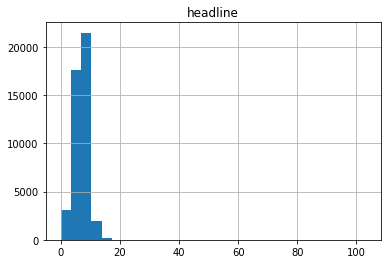

25.0


In [77]:
# finding the maximum length of the news headline in order to do padding
headline = []
# populate the lists with sentence lengths
for i in df['headline']:
      headline.append(len(i.split()))

length_df = pd.DataFrame({'headline':headline})

length_df.hist(bins = 30)
plt.show()
maxlen = np.quantile(length_df['headline'],0.9999)
print(maxlen)

In [78]:
#Converting the training and validation data to sequences and adding zero padding
X_train_seq = tokenizer.texts_to_sequences(X_train.astype("str"))
X_train_pad = pad_sequences(X_train_seq, maxlen=int(maxlen), padding='post')

X_valid_seq = tokenizer.texts_to_sequences(X_valid.astype("str"))
X_valid_pad = pad_sequences(X_valid_seq, maxlen=int(maxlen), padding='post')

In [79]:
X_train_pad.shape, X_valid_pad.shape, y_train.shape, y_valid.shape

((33196, 25), (11066, 25), (33196,), (11066,))

In [80]:
y_train=pd.get_dummies(y_train)
y_valid=pd.get_dummies(y_valid)

In [81]:
y_train.value_counts()

0  1
1  0    17968
0  1    15228
dtype: int64

## Word Embedding

In [82]:
#Implementing word embedding technique - 100 dimension glove to generate dense word vectors 
!pip install gensim
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [93]:
vector_size = 100
gensim_weight_matrix = np.zeros((tokenizer_vocab_size ,vector_size))
gensim_weight_matrix.shape

(28538, 100)

In [ ]:
for word, index in tokenizer.word_index.items():
    if index < tokenizer_vocab_size: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

## Model building & Training

In [125]:
#defining the model - LSTM layer with dropout(to minimise overfitting), fully connected dense layer
model = Sequential()
model.add(Embedding(tokenizer_vocab_size, 100,input_length = int(maxlen), weights = [gensim_weight_matrix]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(1024, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 25, 100)           2853800   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 25, 100)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 1024)              4608000   
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 2050      
Total params: 7,463,850
Trainable params: 7,463,850
Non-trainable params: 0
_________________________________________________________________
None


In [126]:
#Early stopping the model training based on validation loss
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

In [127]:
#training the model
history = model.fit(X_train_pad, y_train, epochs = 25, batch_size = 128, validation_data=(X_valid_pad, y_valid), callbacks=es)

Epoch 1/25
260/260 [==============================] - 71s 262ms/step - loss: 0.5944 - accuracy: 0.6851 - val_loss: 0.4681 - val_accuracy: 0.7826
Epoch 2/25
260/260 [==============================] - 68s 260ms/step - loss: 0.4705 - accuracy: 0.7796 - val_loss: 0.3974 - val_accuracy: 0.8300
Epoch 3/25
260/260 [==============================] - 67s 259ms/step - loss: 0.3806 - accuracy: 0.8325 - val_loss: 0.3339 - val_accuracy: 0.8600
Epoch 4/25
260/260 [==============================] - 68s 260ms/step - loss: 0.3107 - accuracy: 0.8685 - val_loss: 0.2887 - val_accuracy: 0.8765
Epoch 5/25
260/260 [==============================] - 67s 259ms/step - loss: 0.2671 - accuracy: 0.8903 - val_loss: 0.2771 - val_accuracy: 0.8927
Epoch 6/25
260/260 [==============================] - 67s 258ms/step - loss: 0.2137 - accuracy: 0.9144 - val_loss: 0.2597 - val_accuracy: 0.8988
Epoch 7/25
260/260 [==============================] - 67s 259ms/step - loss: 0.1798 - accuracy: 0.9302 - val_loss: 0.2440 - val_ac

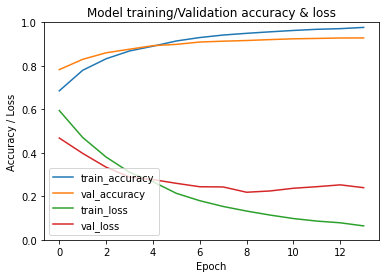

In [129]:
# Model Validation
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model training/Validation accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.show()

## Model Evaluation

In [130]:
#predicting the is_sarcastic label on the validation data
y_hat = model.predict(X_valid_pad)
y_pred = np.argmax(y_hat, axis =1)

y_true = np.argmax(np.array(y_valid), axis=1)

In [135]:
#printing the appropriate evaluation metrics
print('\n Classification Report: \n',classification_report(y_true,y_pred))
print('\n Accuracy Score: {:.2f}'.format(accuracy_score(y_true,y_pred) * 100))
print('\n Precision Score: {:.2f}'.format(precision_score(y_true,y_pred)* 100))
print('\n Recall Score: {:.2f}'.format(recall_score(y_true,y_pred)* 100))
print('\n f1_score: {:.2f}'.format(f1_score(y_true,y_pred)* 100))
print('\n Confusion Matrix \n {}' .format(confusion_matrix(y_true,y_pred)))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      5990
           1       0.91      0.93      0.92      5076

    accuracy                           0.93     11066
   macro avg       0.93      0.93      0.93     11066
weighted avg       0.93      0.93      0.93     11066


 Accuracy Score: 92.83

 Precision Score: 91.13

 Recall Score: 93.48

 f1_score: 92.29

 Confusion Matrix 
 [[5528  462]
 [ 331 4745]]


## Predicting sarcasam for unseen data (test data)

In [136]:
#reading the test data which is unseen by the model
df_test = pd.read_csv("/content/drive/MyDrive/News_Test_Data.csv", index_col=None)

In [137]:
#applying text pre-processing on the test data
df_test['headline'] = df_test['headline'].apply(lambda x: str(x).lower())
df_test['headline'] = df_test['headline'].apply(lambda x: expand_words(x))
df_test['headline'] = df_test['headline'].apply(lambda x: remove_special_characters(x))
df_test['headline'] = df_test['headline'].apply(lambda x: remove_accented_chars(x))
df_test['headline'] = df_test['headline'].apply(lambda x: remove_stopwords(x))

In [138]:
df_test.sample(10)

,headline
2820,violinist sick mozart covers
8039,soccer official says trump presidency hurt world cup bid
7335,ohio mom thanks kind cashier cheered 3yearold son
7557,prevent screen addiction young children
4619,overpopulation earth create valuable new markets
4840,patrick dempseys wife files divorce
6919,trumpnetanyahu meet exercise fawning fantasy antipalestinian incitement
10675,blaming black voter turnout virginia
7128,david blaine stunt push publics endurance limit
9266,france right ban burkini


In [139]:
# tokenizing and padding the test data
X_test_seq = tokenizer.texts_to_sequences(df_test['headline'].astype("str"))
X_test_pad = pad_sequences(X_test_seq, maxlen=int(maxlen), padding='post')

In [140]:
# applying the trained model on the test data and the predictions are saved as a pandas series
df_test_pred = pd.DataFrame()
df_test_pred['prediction'] = np.argmax(model.predict(X_test_pad), axis =1)

In [141]:
# the predictions on the test data are written to a csv
df_test_pred.to_csv("/content/drive/MyDrive/News_predictions_1.csv", index=None)